In [1]:
import scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [4]:
from ppg.common import config
from ppg.common.utils import load_data
from ppg.enums import DataColumn, WavelengthIndex
# from ppg.processing.model import create_regression_data

In [7]:
ts1 = load_data(config.DATA_DIR / 'ppg_curve_0.nc')
ts2 = load_data(config.DATA_DIR / 'ppg_curve_1.nc')

df = pd.read_parquet('../../data/ext.parquet')

ppg_data = df.values

In [8]:
# sampling frequency
Fs = 100
Tstep = 1 / Fs
# number of samples
N = len(ts1[DataColumn.TIME])
Fstep = Fs / N
FILTER_ORDER = 5

In [9]:
TS1_DURATION = max(ts1[DataColumn.TIME][:])
TS2_DURATION = max(ts2[DataColumn.TIME][:])

TS1_BEGIN = datetime.fromisoformat(ts1[DataColumn.PPG_CURVE].meas_datetime)
TS2_BEGIN = datetime.fromisoformat(ts2[DataColumn.PPG_CURVE].meas_datetime)
GAP_DURATION = (TS1_BEGIN - TS2_BEGIN - timedelta(seconds=TS2_DURATION)).seconds

In [185]:
from ppg.processing.normalization import ZscoreNormalization
from ppg.processing.filter import BandPassPaddingFilter
from ppg.processing.missing_values import PolynomialInterpolation
from ppg.processing import Pipeline

pipeline = Pipeline([
    PolynomialInterpolation(),
    ZscoreNormalization(),
    BandPassPaddingFilter(order=config.DEFAULT_FILTER_ORDER,
                          sampling_frequency=Fs,
                          cutoff_frequencies=(0.15, 5),
                          padding_size=Fs * config.FILTER_PADDING_MULTIPLIER),

])

In [186]:
ts1_data = pipeline.process(ts1[DataColumn.PPG_CURVE][:])[:, -9000:]
ts2_data = pipeline.process(ts2[DataColumn.PPG_CURVE][:])[:, :9000]

data_before_gap = ts1_data[WavelengthIndex.RED]
data_after_gap = ts2_data[WavelengthIndex.RED]

gap_data = np.empty((3, GAP_DURATION * Fs))
gap_data[:] = np.nan

ppg_data = np.concatenate((ts1_data, gap_data, ts2_data), axis=1)
time_steps = np.arange(0, ppg_data.shape[1]/Fs, 1/Fs)

In [187]:
signal = ppg_data[WavelengthIndex.RED]
gap_start = np.where(np.isnan(signal))[0][0]
gap_end = np.where(np.isnan(signal))[0][-1] + 1
gap_length = gap_end - gap_start
gap_size = gap_end-gap_start
gap_size

4500

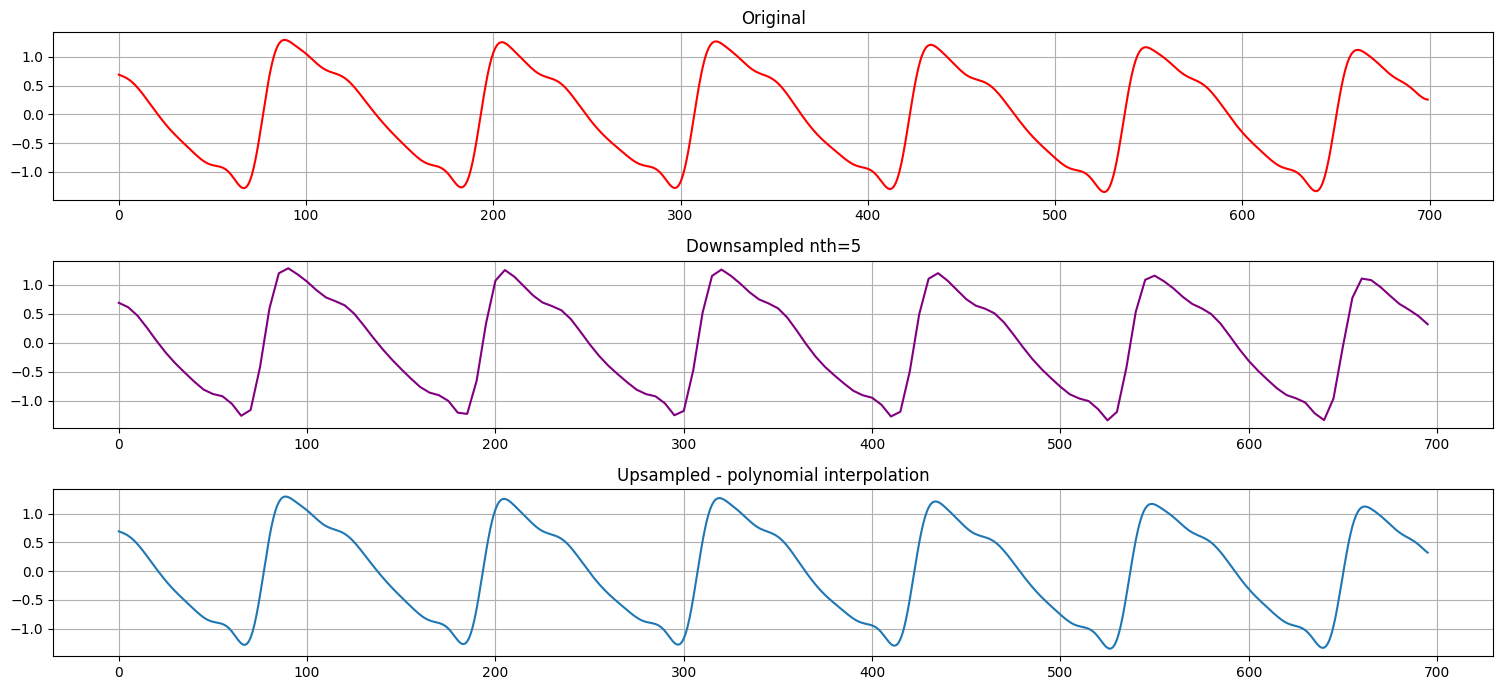

In [188]:
NTH_DOWN_SAMPLING = 5

example = data_before_gap[-700:]
downsampled = pd.Series(example).iloc[::NTH_DOWN_SAMPLING]

upsampled = downsampled.reindex(range(len(example))).interpolate(method='polynomial', order=5)


plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(example, color='red')
plt.title('Original')
plt.grid()

plt.subplot(3,1,2)
plt.plot(downsampled, color='purple')
plt.title('Downsampled nth=5')
plt.grid()

plt.subplot(3,1,3)
plt.plot(upsampled)
plt.title('Upsampled - polynomial interpolation')

plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
N_LAGS = 20
ROLLING_WINDOWS = [50, 150, 700,2000]

x_before,y_before = create_regression_data(data_before_gap, N_LAGS, ROLLING_WINDOWS)
x_after,y_after = create_regression_data(data_after_gap, N_LAGS, ROLLING_WINDOWS)

In [ ]:
x_before

In [ ]:
from sklearn.model_selection import train_test_split

X_before_train, X_before_test, y_before_train, y_before_test = train_test_split(x_before, y_before, test_size=0.2, random_state=42)
X_after_train, X_after_test, y_after_train, y_after_test = train_test_split(x_after, y_after, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pre_gap = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=6)
rf_post_gap = RandomForestRegressor(n_estimators=150, random_state=0, n_jobs=6)

# Fit the models
rf_pre_gap.fit(X_before_train, y_before_train)
rf_post_gap.fit(X_after_train, y_after_train)

In [ ]:
plt.plot(weights)

In [ ]:
x_circular = data_before_gap[-max(ROLLING_WINDOWS + [N_LAGS]) - 1:]
gap_size = gap_end-gap_start

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = sigmoid(np.linspace(-4, 4, gap_size))

predictions = []
for i in range(gap_size):
    x_win,_  = create_regression_data(np.append(x_circular, [80]), n_lags=N_LAGS, rolling_windows=ROLLING_WINDOWS)
    x_win = x_win.tail(1)

    prediction_before = rf_pre_gap.predict(x_win)[0]
    prediction_after = rf_post_gap.predict(x_win)[0]

    # weight = 1 - i/gap_size
    weight = 1 - weights[i]
    prediction = weight*prediction_before + (1-weight)*prediction_after

    # prediction = prediction_before
    x_circular = np.append(x_circular, [prediction])
    predictions.append(prediction)

In [ ]:
plt.figure(figsize=(20,3))
# plt.plot(predictions)
plt.plot(np.concatenate([data_before_gap, predictions, data_after_gap]))

plt.plot(data_before_gap, label='before_gap', color='tab:blue')
plt.plot(np.arange(gap_start, gap_end), predictions, label='gap', color='tab:green')
plt.plot(np.arange(gap_end, gap_end+len(data_after_gap)), data_after_gap, label='after_gap', color='purple')
plt.title('Merged time series')
plt.legend()

In [ ]:
x = concatenate_time_series(data_before_gap, predictions, precision=0.01)
x = concatenate_time_series(x, data_after_gap, precision=0.01)

plt.figure(figsize=(20,3))
plt.plot(x)
plt.title('Merged time series')
plt.axvline(x=gap_start, label='gap_start', color='purple')
plt.axvline(x=gap_end, label='gap_end', color='red')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()

In [ ]:
from ppg.common.utils import concatenate_time_series

CHUNK_SIZE = 1000
x = concatenate_time_series(data_before_gap, predictions, precision=0.01)
x = concatenate_time_series(x, data_after_gap, precision=0.01)

plt.figure(figsize=(20,3))
plt.plot(x[gap_start-CHUNK_SIZE:gap_start], label='before_gap', color='tab:blue')
plt.plot(np.arange(CHUNK_SIZE, CHUNK_SIZE+gap_size), x[gap_start:gap_end], label='gap', color='tab:green')
plt.plot(np.arange(CHUNK_SIZE+gap_size, CHUNK_SIZE+gap_size+CHUNK_SIZE), x[gap_end:gap_end+CHUNK_SIZE], label='after_gap', color='purple')


plt.title('Merged time series')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()

In [ ]:
from scipy.signal import istft, stft
segments = 10
OVERLAP_SIZE = (gap_size // segments)
SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

frequencies, times, complex_data = stft(x, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 10])
plt.axvline(x=gap_start/100, label='gap_start', color='purple')
plt.axvline(x=gap_end/100, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
[1,2,3,4,5,6] / [2]

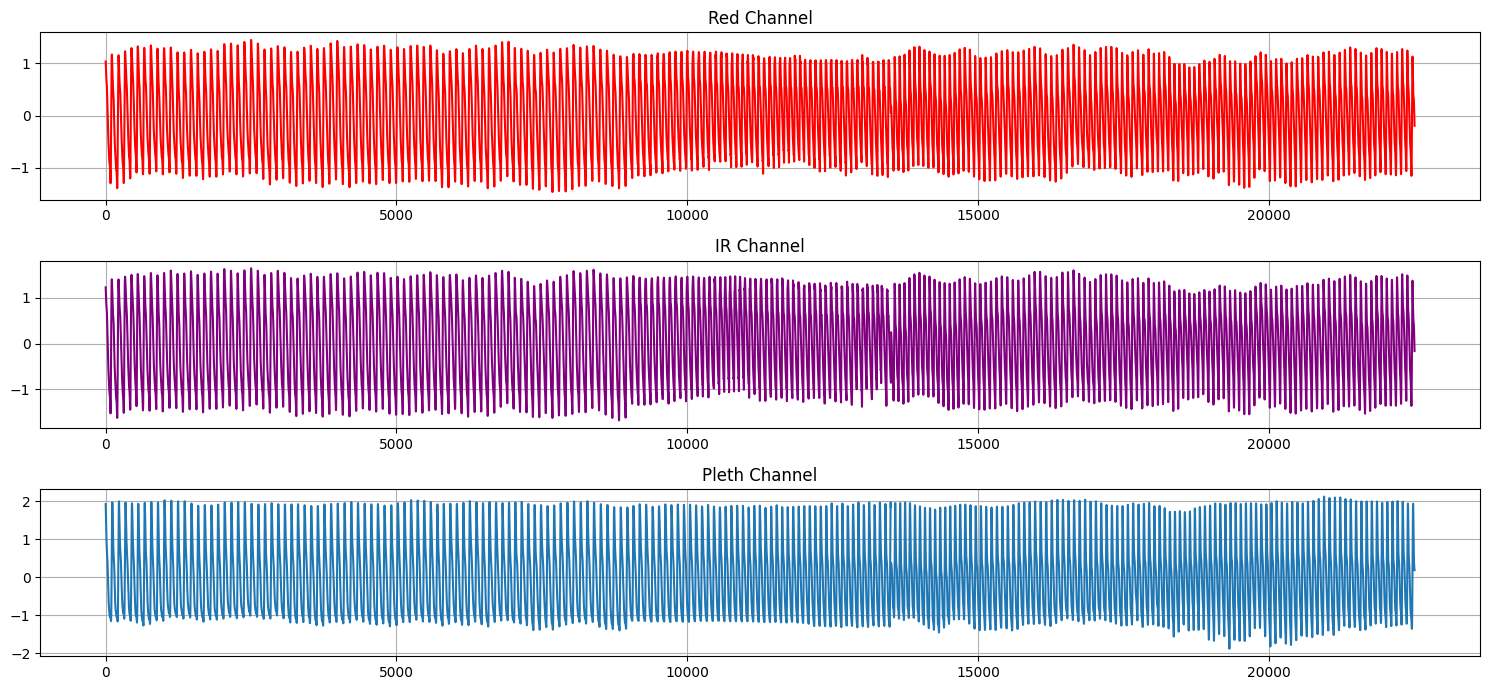

In [21]:
gaps = pd.read_parquet('../../gaps_3.parquet')


plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.RED], gaps['RED'], ts2_data[WavelengthIndex.RED]]), color='red')
plt.title('Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.IR], gaps['IR'], ts2_data[WavelengthIndex.IR]]), color='purple')
plt.title('IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.PLETH], gaps['PLETH'], ts2_data[WavelengthIndex.PLETH]]))
plt.title('Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

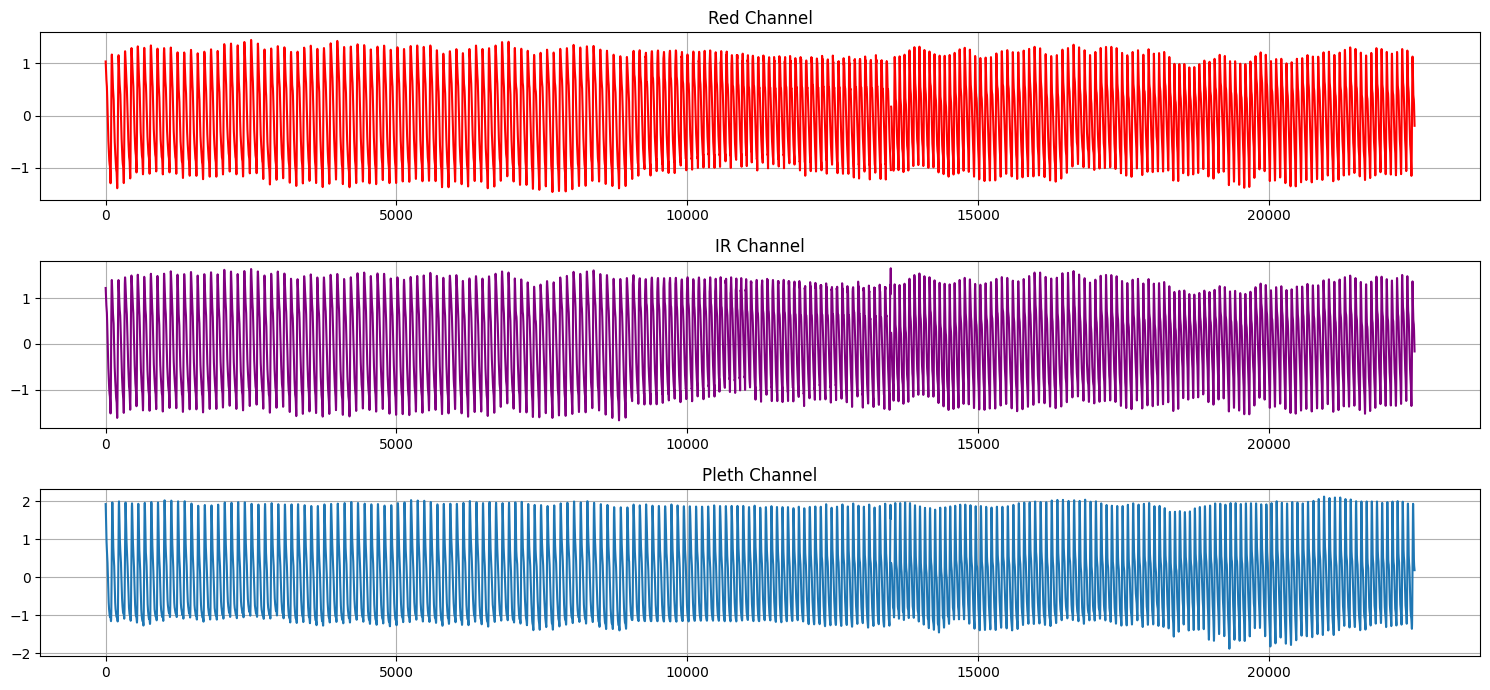

In [24]:
gaps = pd.read_parquet('../../gaps_4.parquet')


plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.RED], gaps['RED'], ts2_data[WavelengthIndex.RED]]), color='red')
plt.title('Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.IR], gaps['IR'], ts2_data[WavelengthIndex.IR]]), color='purple')
plt.title('IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(np.concatenate([ts1_data[WavelengthIndex.PLETH], gaps['PLETH'], ts2_data[WavelengthIndex.PLETH]]))
plt.title('Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [30]:
np.empty((3,3))

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0.,   1.]])

In [74]:
def forward_merge_time_series(s1: np.ndarray,
                                s2: np.ndarray,
                                precision: float = 0.01,
                                max_correlation_phase_shift: int = 200) -> np.ndarray:
    """
    Concatenate two time series by considering phase shift and derivation sign.
    Additional fine alignment is applied to smooth transitions between signals.
    """
    # threshold = np.abs((max(s1) - min(s1)) * precision)
    # alignment_value = s2[0]
    # alignment_gradient_sign = np.sign(np.diff(s2[:2]))
    #
    # # Absolute value & gradient alignment
    # fine_shift_index = 0
    # for i, v in enumerate(reversed(s1)):
    #     difference = np.abs(alignment_value - v)
    #     actual_gradient_sign = np.sign(np.diff(s1[-i - 2:-i]))
    #     if difference <= threshold and alignment_gradient_sign == actual_gradient_sign:
    #         fine_shift_index = i
    #         break

    FLEX_SIZE = 3

    # Mering and final interpolations to fill possible missing values in interfaces
    result = np.concatenate([s1[:-FLEX_SIZE], [np.NAN for _ in range(FLEX_SIZE*2)], s2[FLEX_SIZE:]])
    result = pd.DataFrame(result).interpolate(method='polynomial', order=1).values

    return result


In [86]:


gaps

,PLETH,RED,IR
0,0.122018,-0.375434,-0.387554
1,0.110005,-0.400172,-0.418668
2,0.087748,-0.442064,-0.472345
3,0.057851,-0.490019,-0.536025
4,0.022450,-0.535050,-0.599176
...,...,...,...
29069,1.486873,0.962624,1.076370
29070,1.765739,0.938760,1.048732
29071,1.995191,0.910630,1.015475
29072,2.159749,0.884043,0.983742


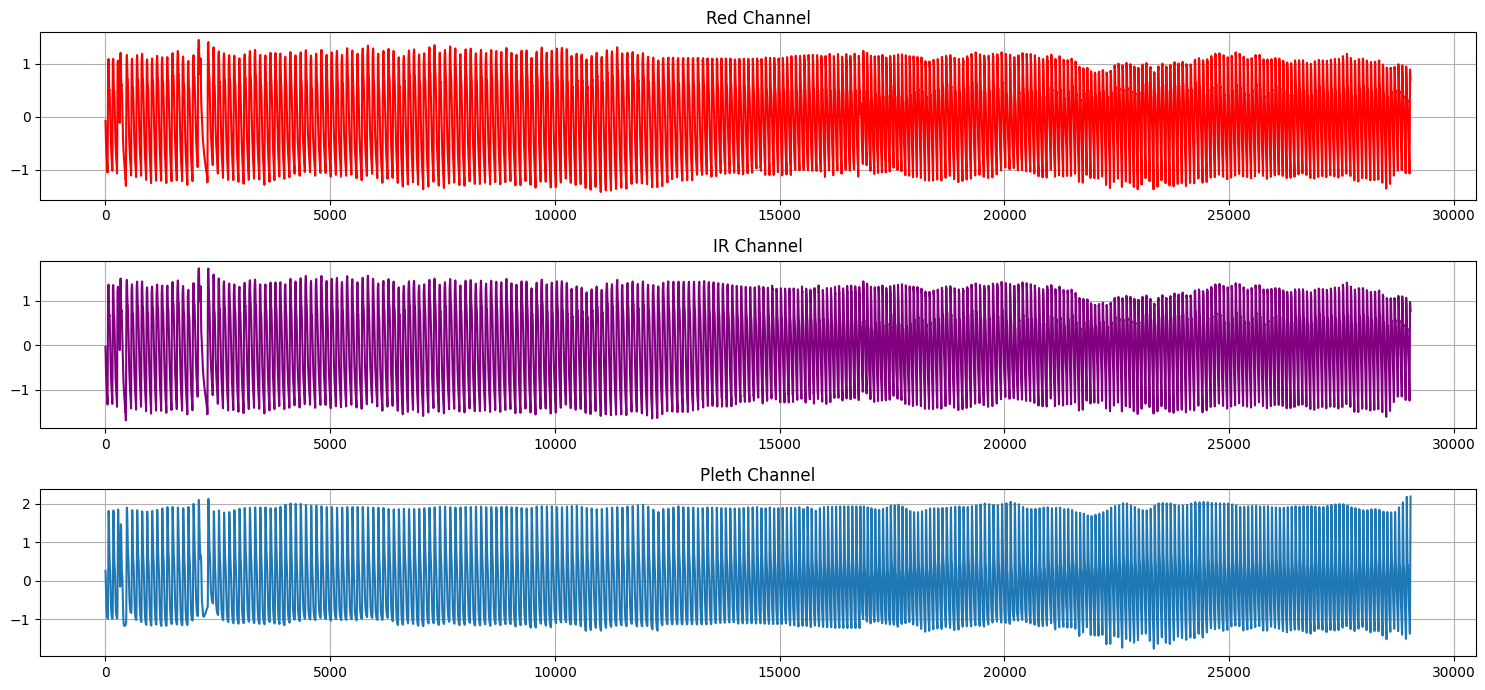

In [207]:
merged = pd.read_parquet('../../data/output/merged.parquet')


plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(merged['RED'], color='red')
plt.title('Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(merged['IR'], color='purple')
plt.title('IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(merged['PLETH'])
plt.title('Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

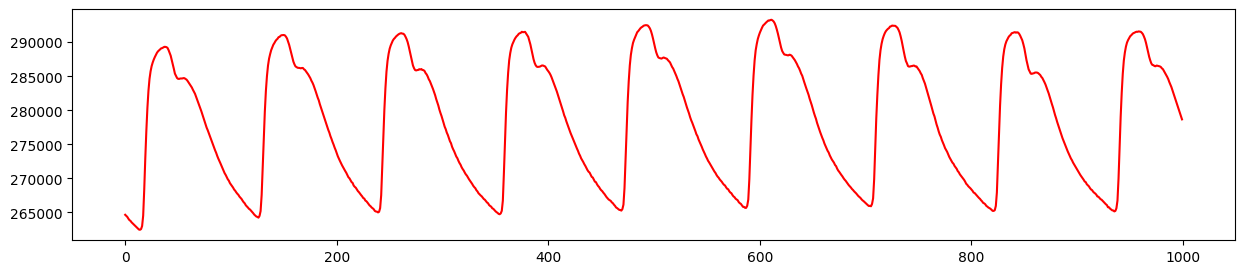

In [201]:
plt.figure(figsize=(15,3))
plt.plot(ts1[DataColumn.PPG_CURVE][WavelengthIndex.RED][1000:2000], color='red')

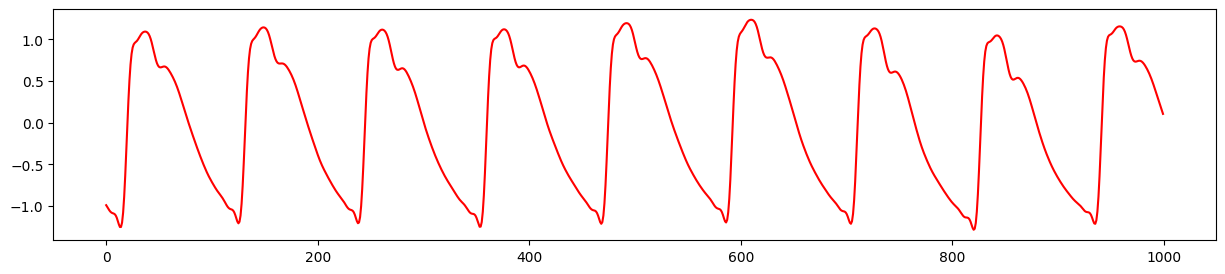

In [203]:
plt.figure(figsize=(15,3))
plt.plot(merged['RED'].values[1000:2000], color='red')

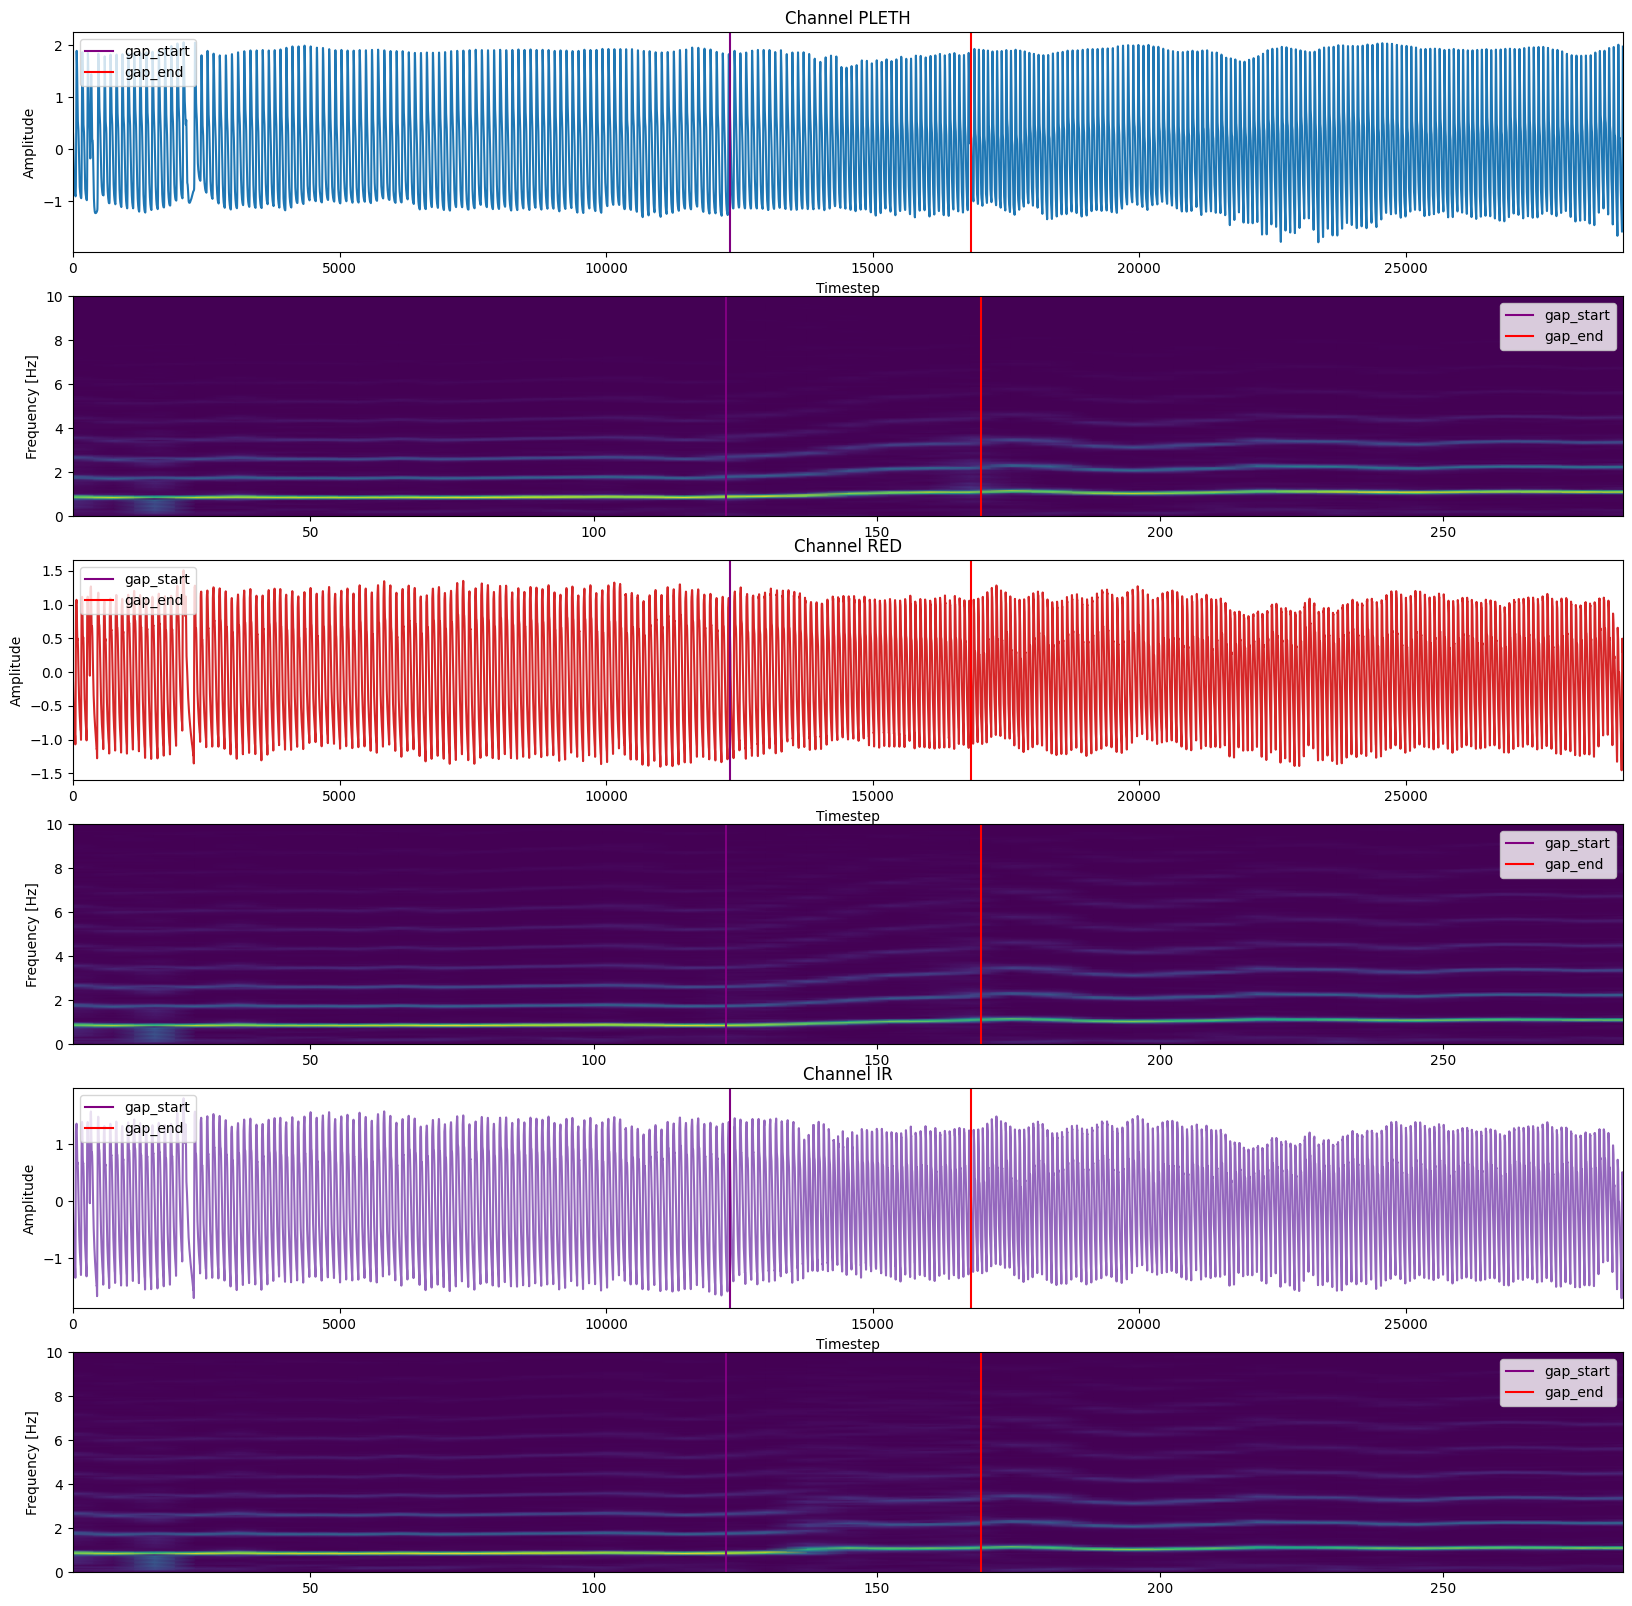

In [147]:
from scipy.signal import stft

def plot_results(data: pd.DataFrame, gap_start, gap_end, fs, stft_segments_per_gap):

    gap_size = gap_end - gap_start
    OVERLAP_SIZE = (gap_size // stft_segments_per_gap)
    SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / stft_segments_per_gap) + OVERLAP_SIZE)

    fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(20,20))

    colors = ['tab:blue', 'tab:red', 'tab:purple']
    for i, (col, color) in enumerate(zip(data.columns, colors)):
        x = data[col].values

        frequencies, times, Zxx = stft(x, fs=fs, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

        ax[i*2].plot(x, color=color)
        ax[i*2].axvline(x=gap_start, label='gap_start', color='purple')
        ax[i*2].axvline(x=gap_end, label='gap_end', color='red')
        ax[i*2].set_title(f'Channel {col}')
        ax[i*2].set_xlim(0, len(x))
        ax[i*2].set_xlabel('Timestep')
        ax[i*2].set_ylabel('Amplitude')
        ax[i*2].legend(loc='upper left')

        ax[i*2+1].pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
        ax[i*2+1].set_ylim([0, 10])
        ax[i*2+1].axvline(x=gap_start/fs, label='gap_start', color='purple')
        ax[i*2+1].axvline(x=gap_end/fs, label='gap_end', color='red')
        ax[i*2+1].set_ylabel('Frequency [Hz]')
        ax[i*2+1].legend(loc='upper right')

    plt.show()


plot_results(data=merged, gap_start=ts1[DataColumn.PPG_CURVE].shape[1], gap_end=merged.shape[0] - ts2[DataColumn.PPG_CURVE].shape[1], stft_segments_per_gap=5, fs=100)